In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Farmland & Crops Keras EfficientNet


## Import Package


In [1]:
import os
import time
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    # Show GPU information
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

## Const & Inputs

Here are all of the parameters to change for the run.


In [4]:
# top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
# path = "/content/drive/MyDrive/Colab Notebooks"
path = "."

# Number of classes in the dataset
num_classes = 14

# Image size for model
image_size = 224

# Get the shape of the input layer
input_shape = (image_size, image_size, 3)

In [9]:
from utils.metrics import evaluate
from utils.image import load_image_and_resize
from utils.model import get_reducelr, get_checkpoint, get_early_stop

Tensorflow version 2.6.0


## Data Preprocessing

Include: laod data, encode categorical features, split data, normalize data, and save data.


### Load Data

The training set has been randomly split into train(85%) and valid(15%) in advance.


In [12]:
fullset = pd.read_csv(f'{path}/data/describe_train_fullset.csv')
fullset.shape

(80270, 8)

In [10]:
train = fullset[fullset['set_name'].eq('train')].reset_index(drop=True)
valid = fullset[fullset['set_name'].eq('valid')].reset_index(drop=True)
test = pd.read_csv(f'{path}/data/describe_test.csv')
test.shape

(20000, 8)

We can choose to process the data from scratch, or read data that has already been processed.


In [14]:
# train
tqdm.pandas()
train["vector"] = train['path'].progress_apply(lambda x: load_image_and_resize(f'{path}/data/train/{x}', new_size=224, resize_method="resize"))
train.to_pickle(f'{path}/data/train_vector_224.pkl')
# valid
tqdm.pandas()
valid["vector"] = valid['path'].progress_apply(lambda x: load_image_and_resize(f'{path}/data/train/{x}', new_size=224, resize_method="resize"))
valid.to_pickle(f'{path}/data/valid_vector_224.pkl')
tqdm.pandas()
# test
test["vector"] = test['path'].progress_apply(lambda x: load_image_and_resize(f'{path}/data/test/{x}', new_size=224, resize_method="resize"))
test.to_pickle(f'{path}/data/test_vector_224.pkl')

In [18]:
x_train_vector = np.array(train['vector'].tolist())
x_valid_vector = np.array(valid['vector'].tolist())
x_test_vector = np.array(test['vector'].tolist())

### Encode categorical features

OneHotEncoder or LabelEncoder.


In [21]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(fullset['label'].values.reshape(-1, 1))
y_train = np.array(enc.transform(train['label'].values.reshape(-1, 1)).toarray().tolist())
y_valid = np.array(enc.transform(valid['label'].values.reshape(-1, 1)).toarray().tolist())

## EfficientNet modelling + training

Using EfficientNetB0~B7.


### Initialize and Reshape the Networks


In [22]:
from sklearn.utils import class_weight
sample_weight = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [26]:
def get_model(input_shape, num_classes, dropout=0.2):
    inputs = tf.keras.layers.Input(shape=input_shape)
    model = tf.keras.applications.EfficientNetB6(include_top=False, weights='imagenet', input_tensor=inputs)
    
     # Freeze the pretrained weights
    model.trainable = True
    
     # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout, name="top_dropout")(x)
    x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_uniform(seed=None))(x)
    outputs = tf.keras.layers.Dense(units=num_classes, activation='softmax', kernel_initializer=tf.keras.initializers.he_uniform(seed=None), name="pred")(x)
    
    # Compile
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="EfficientNet")
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [ ]:
# [10, 30, 50, 100, 150]
epochs = 150

# [16, 32(default), 64, 128, 256, 512, 1024]
batch_size = 64

# Define model name
model_name = f'efficientnetb6-transfer-trainable-epochs{epochs}-batchsize{batch_size}-lrreducer-dropout20-sampleweight-{input_shape[0]}'

### Modelling


In [27]:
with strategy.scope():    
    model = get_model(input_shape, num_classes)
    model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

c:\Users\siang\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
start = time.time()

history = model.fit(
    x_train_vector, y_train,
    initial_epoch=0,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_valid_vector, y_valid),
    verbose=2, # progress bar
    sample_weight=sample_weight,
    callbacks=[
        get_checkpoint(f'{path}/models/{model_name}.h5', 'val_categorical_accuracy'), 
        get_early_stop(30),
        get_reducelr(),
    ],
)

end = time.time()
print(format(end-start))

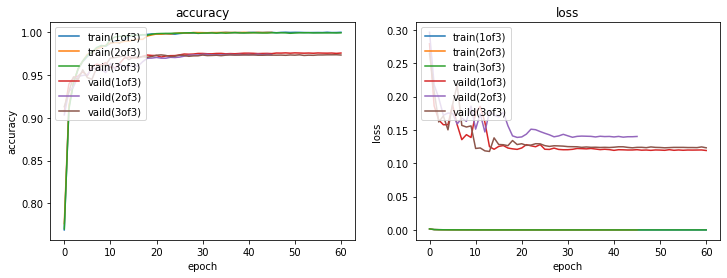

In [45]:
logs = [
    'efficientnetb0-transfer-trainable-fullset1of3-epochs150-batchsize32-lrreducer-dropout20-sampleweight-224',
    'efficientnetb0-transfer-trainable-fullset2of3-epochs150-batchsize32-lrreducer-dropout20-sampleweight-224',
    'efficientnetb0-transfer-trainable-fullset3of3-epochs150-batchsize32-lrreducer-dropout20-sampleweight-224',
]

b3log1 = pd.read_csv(f'./logs/efficientnet-fullset/{logs[0]}.csv')
b3log2 = pd.read_csv(f'./logs/efficientnet-fullset/{logs[1]}.csv')
b3log3 = pd.read_csv(f'./logs/efficientnet-fullset/{logs[2]}.csv')

plt.figure(figsize=(12, 4))

# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(b3log1['categorical_accuracy'])
plt.plot(b3log2['categorical_accuracy'])
plt.plot(b3log3['categorical_accuracy'])
plt.plot(b3log1['val_categorical_accuracy'])
plt.plot(b3log2['val_categorical_accuracy'])
plt.plot(b3log3['val_categorical_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([
    'train(1of3)', 'train(2of3)', 'train(3of3)',
    'vaild(1of3)', 'vaild(2of3)', 'vaild(3of3)'
], loc='upper left') 

# summarize history for loss 
plt.subplot(1, 2, 2)
plt.plot(b3log1['loss']) 
plt.plot(b3log2['loss']) 
plt.plot(b3log3['loss']) 
plt.plot(b3log1['val_loss']) 
plt.plot(b3log2['val_loss']) 
plt.plot(b3log3['val_loss']) 
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend([
    'train(1of3)', 'train(2of3)', 'train(3of3)',
    'vaild(1of3)', 'vaild(2of3)', 'vaild(3of3)'
], loc='upper left') 
plt.show()

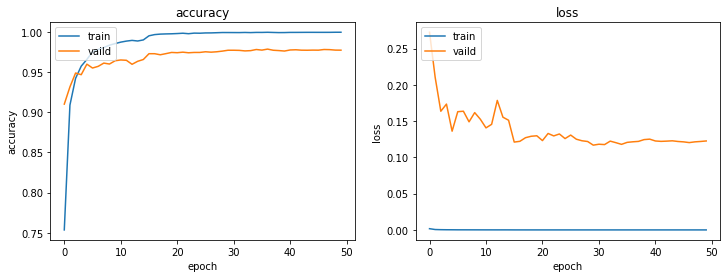

In [23]:
b6log = pd.read_csv(f'{path}/logs/efficientnet-fullset/efficientnetb6-transfer-trainable-fullset-epochs150-batchsize64-lrreducer-dropout20-sampleweight-224.csv')

plt.figure(figsize=(12, 4))

# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(b6log['categorical_accuracy'])
plt.plot(b6log['val_categorical_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'vaild'], loc='upper left') 

# summarize history for loss 
plt.subplot(1, 2, 2)
plt.plot(b6log['loss']) 
plt.plot(b6log['val_loss']) 
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'vaild'], loc='upper left') 
plt.show()

### Prediction

Prediction based on the best model during training


In [24]:
# Load model with the best validation accuracy
model_name = "efficientnet-fullset-/efficientnetb3-transfer-trainable-fullset1of3-epochs150-batchsize32-lrreducer-dropout20-sampleweight-224"
model = get_model(input_shape, num_classes)
model.load_weights(f'{path}/models/{model_name}.h5')

In [ ]:
# Predict the response for valid dataset
y_valid_pred = model.predict(x_valid_vector, verbose=1)

# Transform the encoded predictions to their actual values
y_valid_pred_inverse = enc.inverse_transform(y_valid_pred).reshape(-1)
y_valid_inverse = enc.inverse_transform(y_valid).reshape(-1)

# Add to DataFrame
valid['predict_prob'] = list(y_valid_pred)
valid['pred_label'] = list(y_valid_pred_inverse)

# Evaluate the model
evaluation = evaluate(y_valid_inverse.tolist(), y_valid_pred_inverse.tolist())
pd.DataFrame(evaluation).T

In [ ]:
# Predict the response for test dataset
y_test_pred = model.predict(x_test_vector, verbose=1)

# Transform the encoded predictions to their actual values
y_test_pred_inverse = enc.inverse_transform(y_test_pred).reshape(-1)

# Add to DataFrame
test['predict_prob'] = list(y_test_pred)
test['pred_label'] = list(y_test_pred_inverse)

### Save Results

filename: \*.pkl  
pandas toprotocol: 4  
class order: ['banana', 'bareland', 'carrot', 'corn', 'dragonfruit', 'garlic', 'guava', 'peanut', 'pineapple', 'pumpkin', 'rice', 'soybean', 'sugarcane', 'tomato']


In [67]:
# path: str, ex: banana/123-456.jpg  
# set_name: str, ['train', 'valid', 'test']  
# true_label: str  
# pred_label: str  
# taken_datetime: str  
# predict_prob: List[float], predict probabilities of 14 classes (order by alphabet)  

In [ ]:
# Copy from train, valid or test
result = valid.copy()

# Select columns
result = valid[[
    'path', 'set_name', 'true_label',
    'predict_prob_1of3', 'pred_label_1of3',
    'predict_prob_2of3', 'pred_label_2of3', 
    'predict_prob_3of3', 'pred_label_3of3',
    'predict_prob', 'pred_label',
]]

# Only keep filename from path
# result['path'] = result['path'].apply(lambda x: '/'.join(x.split('//')[4:]))

# Save the results to pkl file
# write_pkl(result, f'./results/{model_name}-valid.pkl')